In [1]:
%matplotlib inline

# Predict pose using pretrained GluonCV models

In [2]:
from matplotlib import pyplot as plt
from gluoncv import model_zoo, data, utils
from gluoncv.data.transforms.pose import detector_to_simple_pose, heatmap_to_coord

Load a pretrained model
-------------------------

Let's get a Simple Pose model trained with input images of size 256x192 on MS COCO
dataset. We pick the one using ResNet-18 V1b as the base model. By specifying
``pretrained=True``, it will automatically download the model from the model
zoo if necessary. For more pretrained models, please refer to
https://gluon-cv.mxnet.io/model_zoo/pose.html.

Note that a Simple Pose model takes a top-down strategy to estimate
human pose in detected bounding boxes from an object detection model.



In [3]:
detector = model_zoo.get_model('yolo3_mobilenet1.0_coco', pretrained=True)
pose_net = model_zoo.get_model('simple_pose_resnet18_v1b', pretrained=True)

# Note that we can reset the classes of the detector to only include
# human, so that the NMS process is faster.

detector.reset_class(["person"], reuse_weights=['person'])

Pre-process an image for detector, and make inference
--------------------

Next we download an image, and pre-process with preset data transforms. Here we
specify that we resize the short edge of the image to 512 px. But you can
feed an arbitrarily sized image.

This function returns two results. The first is a NDArray with shape
``(batch_size, RGB_channels, height, width)``. It can be fed into the
model directly. The second one contains the images in numpy format to
easy to be plotted. Since we only loaded a single image, the first dimension
of `x` is 1.



In [4]:
im_fname = utils.download('https://github.com/dmlc/web-data/blob/master/' +
                          'gluoncv/pose/soccer.png?raw=true',
                          path='soccer.png')
x, img = data.transforms.presets.ssd.load_test(im_fname, short=512)
print('Shape of pre-processed image:', x.shape)

class_IDs, scores, bounding_boxs = detector(x)

Shape of pre-processed image: (1, 3, 512, 605)


Process tensor from detector to keypoint network
--------------------

Next we process the output from the detector.

For a Simple Pose network, it expects the input has the size 256x192,
and the human is centered. We crop the bounding boxed area
for each human, and resize it to 256x192, then finally normalize it.

In order to make sure the bounding box has included the entire person,
we usually slightly upscale the box size.



In [5]:
pose_input, upscale_bbox = detector_to_simple_pose(img, class_IDs, scores, bounding_boxs)

Predict with a Simple Pose network
--------------------

Now we can make prediction.

A Simple Pose network predicts the heatmap for each joint (i.e. keypoint).
After the inference we search for the highest value in the heatmap and map it to the
coordinates on the original image.



In [6]:
predicted_heatmap = pose_net(pose_input)
pred_coords, confidence = heatmap_to_coord(predicted_heatmap, upscale_bbox)

Display the pose estimation results
---------------------

We can use `gluoncv.utils.viz.plot_keypoints` to visualize the
results.



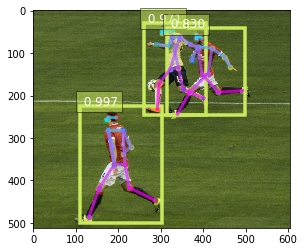

In [7]:
ax = utils.viz.plot_keypoints(img, pred_coords, confidence,
                              class_IDs, bounding_boxs, scores,
                              box_thresh=0.5, keypoint_thresh=0.2)
plt.show()

Dive deep into Training a Simple Pose Model on COCO Keypoints
===================================================================

In this tutorial, we show you how to train a pose estimation model [1]_ on the COCO dataset.

First let's import some necessary modules.


In [8]:
from __future__ import division

import time, logging, os, math

import numpy as np
import mxnet as mx
from mxnet import gluon, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.data import mscoco
from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, LRScheduler
from gluoncv.data.transforms.presets.simple_pose import SimplePoseDefaultTrainTransform
from gluoncv.utils.metrics import HeatmapAccuracy

Loading the data
----------------

We can load COCO Keypoints dataset with their official API




In [9]:
train_dataset = mscoco.keypoints.COCOKeyPoints('~/.mxnet/datasets/coco',
                                               splits=('person_keypoints_train2017'))

loading annotations into memory...
Done (t=7.62s)
creating index...
index created!


The dataset object enables us to retrieve images containing a person,
the person's keypoints, and meta-information.

Following the original paper, we resize the input to be ``(256, 192)``.
For augmentation, we randomly scale, rotate or flip the input.
Finally we normalize it with the standard ImageNet statistics.

The COCO keypoints dataset contains 17 keypoints for a person.
Each keypoint is annotated with three numbers ``(x, y, v)``, where ``x`` and ``y``
mark the coordinates, and ``v`` indicates if the keypoint is visible.

For each keypoint, we generate a gaussian kernel centered at the ``(x, y)`` coordinate, and use
it as the training label. This means the model predicts a gaussian distribution on a feature map.




In [10]:
transform_train = SimplePoseDefaultTrainTransform(num_joints=train_dataset.num_joints,
                                                  joint_pairs=train_dataset.joint_pairs,
                                                  image_size=(256, 192), heatmap_size=(64, 48),
                                                  scale_factor=0.30, rotation_factor=40, random_flip=True)

Now we can define our data loader with the dataset and transformation. We will iterate
over ``train_data`` in our training loop.




In [11]:
batch_size = 32
train_data = gluon.data.DataLoader(
    train_dataset.transform(transform_train),
    batch_size=batch_size, shuffle=True, last_batch='discard', num_workers=8)

Deconvolution Layer
-------------------

A deconvolution layer enlarges the feature map size of the input,
so that it can be seen as a layer upsamling the input feature map.

![](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides_transposed.gif)

    :width: 40%
    :align: center

In the above image, the blue map is the input feature map, and the cyan map is the output.

In a ``ResNet`` model, the last feature map shrinks its height and width to be only 1/32 of the input. It may
be too small for a heatmap prediction. However if followed by several deconvolution layers, the feature map
can have a larger size thus easier to make the prediction.



Model Definition
-----------------

A Simple Pose model consists of a main body of a resnet, and several deconvolution layers.
Its final layer is a convolution layer predicting one heatmap for each keypoint.

Let's take a look at the smallest one from the GluonCV Model Zoo, using ``ResNet18`` as its base model.

We load the pre-trained parameters for the ``ResNet18`` layers,
and initialize the deconvolution layer and the final convolution layer.



In [12]:
context = mx.gpu(0)
net = get_model('simple_pose_resnet18_v1b', num_joints=17, pretrained_base=True,
                ctx=context, pretrained_ctx=context)
net.deconv_layers.initialize(ctx=context)
net.final_layer.initialize(ctx=context)

We can take a look at the summary of the model



In [13]:
x = mx.nd.ones((1, 3, 256, 192), ctx=context)
net.summary(x)

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (1, 3, 256, 192)               0
            Conv2D-1                            (1, 64, 128, 96)            9408
 BatchNormCudnnOff-2                            (1, 64, 128, 96)             256
        Activation-3                            (1, 64, 128, 96)               0
         MaxPool2D-4                             (1, 64, 64, 48)               0
            Conv2D-5                             (1, 64, 64, 48)           36864
 BatchNormCudnnOff-6                             (1, 64, 64, 48)             256
        Activation-7                             (1, 64, 64, 48)               0
            Conv2D-8                             (1, 64, 64, 48)           36864
 BatchNormCudnnOff-9                             (1, 64, 64, 48)             256
       Activation-10        

Training Setup
--------------

Next, we can set up everything for the training.

- Loss:

    We apply a weighted ``L2Loss`` on the predicted heatmap, where the weight is
    1 if the keypoint is visible, otherwise is 0.




In [14]:
L = gluon.loss.L2Loss()

- Learning Rate Schedule and Optimizer:

    We use an initial learning rate at 0.001, and divide it by 10 at the 90th and 120th epoch.




In [15]:
num_training_samples = len(train_dataset)
num_batches = num_training_samples // batch_size
lr_scheduler = LRScheduler(mode='step', base_lr=0.001,
                           iters_per_epoch=num_batches, nepochs=140,
                           step_epoch=(90, 120), step_factor=0.1)

For this model we use ``adam`` as the optimizer.



In [16]:
trainer = gluon.Trainer(net.collect_params(), 'adam', {'lr_scheduler': lr_scheduler})

- Metric

    The metric for this model is called heatmap accuracy, i.e. it compares the
    keypoint heatmaps from the prediction and groundtruth and check if the center
    of the gaussian distributions are within a certain distance.



In [17]:
metric = HeatmapAccuracy()

Training Loop
-------------

Since we have all necessary blocks, we can now put them together to start the training.




In [18]:
net.hybridize(static_alloc=True, static_shape=True)
for epoch in range(1):
    metric.reset()

    for i, batch in enumerate(train_data):
        if i > 0:
            break
        data = gluon.utils.split_and_load(batch[0], ctx_list=[context], batch_axis=0)
        label = gluon.utils.split_and_load(batch[1], ctx_list=[context], batch_axis=0)
        weight = gluon.utils.split_and_load(batch[2], ctx_list=[context], batch_axis=0)

        with ag.record():
            outputs = [net(X) for X in data]
            loss = [L(yhat, y, w) for yhat, y, w in zip(outputs, label, weight)]

        for l in loss:
            l.backward()
        trainer.step(batch_size)

        metric.update(label, outputs)

    break

Due to limitation on the resources, we only train the model for one batch in this tutorial.

Please checkout the full [training script](https://github.com/dmlc/gluon-cv/blob/master/scripts/pose/simple_pose/train_simple_pose.py) to reproduce our results.

References
----------

.. [1] Xiao, Bin, Haiping Wu, and Yichen Wei. \
       "Simple baselines for human pose estimation and tracking." \
       Proceedings of the European Conference on Computer Vision (ECCV). 2018.
.. [2] https://github.com/Microsoft/human-pose-estimation.pytorch/issues/48
.. [3] https://github.com/PaddlePaddle/models/tree/develop/fluid/PaddleCV/human_pose_estimation#known-issues

